# Pareto decoding 
$$
\newcommand{\ww}[0]{\boldsymbol{w}}
\newcommand{\uu}[0]{\boldsymbol{u}}
\newcommand{\vv}[0]{\boldsymbol{v}}
\newcommand{\yy}[0]{\boldsymbol{y}}
$$
<font color="red">This notebook is a work in progress.</font>

In this notebook, we will look at a modification of the typical argmax decoding problem,
$$
\yy^{\star}(\ww) = \underset{\yy \in \mathcal{Y}}{\mathrm{argmax}}\ \ww^\top \yy
$$

where $\yy \in \mathcal{Y}$ is a vector of edge (or hyperedge) inclusions indicator functions from a set of feasible structures $\mathcal{Y}$.  The set is assumed to be compactly described by a B-hypergraph.

The specific extension we will consider is to simultaneously decode under *all* linear combinations to two weight vectors, $w = \alpha \uu + \beta \vv$.  The following set is called the set of Pareto optimal combinations of $\uu$ and $\vv$,
$$
\mathcal{P}(\uu,\vv) = \Big\{ \yy^{\star}(\alpha \uu + \beta \vv) \ \Big|\ \alpha, \beta \in \mathbb{R} \Big\}
$$


Where do these edge functions come from?
 - The two edge scoring functions can come from competing feature weights.  Pareto decoding can be used to do exact and efficient line search for how to combine the weight vectors. (TODO: citations Och, Dyer's tutorial)
 - One of the edge scoring functions can be an evaluation metric (assuming it can be encoded as an additive function over the edges of the hypergraph).  Thus, the Pareto set is the set of all possible "hope" and "fear" predictions (TODO:cite David Chiang, Kevin Gimpel).
 - In the context of reinforcement learning, the two weight vector could be two reward functions.  And the system will then identify the set of all Parteo optimal policies for combinations of those reward functions (TODO: citations).
 
Quite surprisingly, the set $\mathcal{P}$ is polynomial in the size of the size of the hypergraph and it can be computed efficiently (TODO: give a tighter bounds and citations).  How??? The convex hull semiring.

In [1]:
import numpy as np, pylab as pl
from hypergraphs.semirings import LazySort, ConvexHull, Point, post_process
from hypergraphs.apps.parser2 import parse, load_grammar

In [2]:
def binary(sentence,X,Y,Z,i,j,k):
    return ConvexHull([Point(w1(X,Y,Z,i,j,k), w2(X,Y,Z,i,j,k), X)])

def unary(sentence,X,Y,i,k):
    return ConvexHull([Point(w1(X,Y,i,k), w2(X,Y,i,k), X)])

def terminal(sentence,W,i):
    return ConvexHull([Point(0.0, 0.0, W)])

from arsenal.cache import memoize
w1 = memoize(lambda *edge: np.random.uniform(-1,1))
w2 = memoize(lambda *edge: np.random.uniform(-1,1))

sentence = 'Papa ate the caviar with the spoon .'.split()

grammar = load_grammar("""
S       X .
X       X X
X       Papa
X       ate
X       the
X       caviar
X       with
X       spoon
X       in
X       park
""")

root = parse(sentence, grammar, binary, unary, terminal, zero = ConvexHull([]))[0,len(sentence),'S']

Below, we plot the convex hull found.  The x-axis and y-axis are the scores under the different weight vectors.

- *TODO*: label the axes.

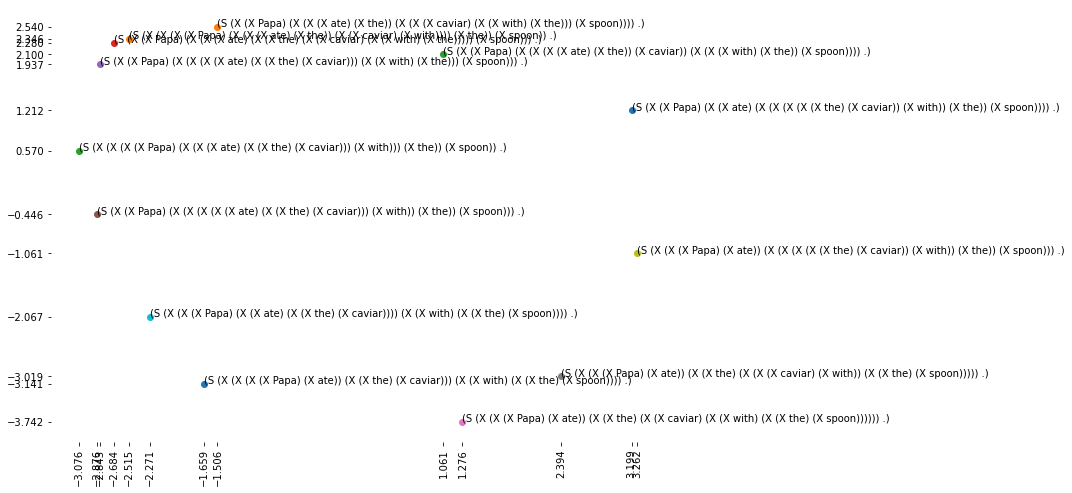

In [3]:
import re
ax = pl.figure(figsize=(11,8)).add_subplot(111)
pl.box(False)
pl.xticks([x.m for x in root], rotation='vertical')
pl.yticks([x.b for x in root])
for x in root:
    pl.scatter(x.m, x.b)
    pl.text(x=x.m, y=x.b, s=re.sub('\s+', ' ', str(x.derivation())))

**TODO**

- Explain what Pareto decoding is (i.e., decoding under all combinations of two edge scoring functions); 
  - unit-test that the interpretation is correct.
- Clean up the creation of the hypergraph and the scoring
- Visualize *every* parse in the two-dimensional plot and show that we are only selecting the one on the convex hull.  This is the main different between `ConvexHull` (polytime) and `LazySort` (exptime).
- Convex hull semiring is max-plus so it requires working with log-weights

In [4]:
def binary(sentence,X,Y,Z,i,j,k): return LazySort(np.exp(w1(X,Y,Z,i,j,k)), X)
def unary(sentence,X,Y,i,k): return LazySort(np.exp(w1(X,Y,i,k)), X)
def terminal(sentence,W,i): return LazySort(1.0, W)
root1 = parse(sentence, grammar, binary, unary, terminal, zero = LazySort.zero())[0,len(sentence),'S']

In [5]:
def binary(sentence,X,Y,Z,i,j,k): return LazySort(np.exp(w2(X,Y,Z,i,j,k)), X)
def unary(sentence,X,Y,i,k): return LazySort(np.exp(w2(X,Y,i,k)), X)
def terminal(sentence,W,i): return LazySort(1.0, W)
root2 = parse(sentence, grammar, binary, unary, terminal, zero = LazySort.zero())[0,len(sentence),'S']

In [6]:
d1 = {str(x.data): np.log(x.score) for x in root1}
d2 = {str(x.data): np.log(x.score) for x in root2}

In the plot below, every point corresponds to a $\yy \in \mathcal{Y}$ and its $x--y$ coordinates are $(\uu^\top \yy, \vv^\top \yy)$.  I have highlighted in red the points that are in the set $\mathcal{P}$---i.e., the points that are on the convex hull of the point cloud.

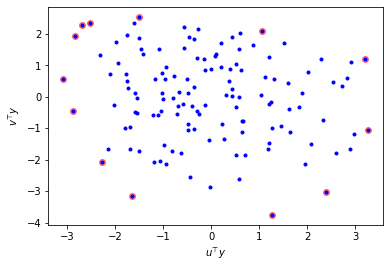

In [13]:
for x in d1:
    pl.scatter(d1[x], d2[x], c='b', marker='.')
for x in root:
    pl.scatter(x.m, x.b, c='r', alpha=0.5, zorder=-1)
pl.xlabel(r'${u}^\top {y}$'); pl.ylabel(r'${v}^\top {y}$');

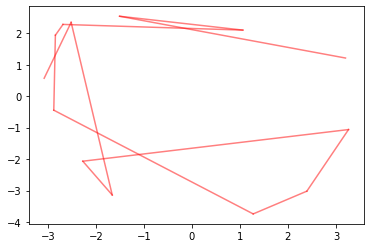

In [8]:
# TODO: return points in convex hull order!
from arsenal.iterextras import window
for x, y in window(root, 2):
    pl.plot([x.m, y.m], [x.b, y.b], c='r', alpha=0.5, zorder=-1)